## reproduce Part II publication, 6 panel bin plots that show database stats

In [1]:
%matplotlib widget
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("/network/rit/lab/sulialab/share/IPAS_3radii/")
import scripts.database as database

import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [3]:
large = 20; med = 16; small = 14
params = {'axes.titlesize': med,
          'legend.fontsize': small,
          'figure.figsize': (7,7),
          'axes.labelsize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          "font.family": "serif"}
plt.rcParams.update(params)

In [ ]:
# note these files are not made available on git

In [39]:
orientation = 'rand'  # chose which orientation (rand or flat)
if orientation == 'rand':
    files = "../instance_files/parquet_files/createdb_iceagg_rand*"
    title = 'Random Orientation'
else:
    files = "../instance_files/parquet_files/createdb_iceagg_flat*"
    title = 'Quasi-Horizontal Orientation'

#### read databases (parquet files don't include agg points) and calculate aggregate shape, aspect ratio, and radius

In [14]:
%%time
#READ DATABASE 
db = database.Database(files)
db.read_database_parquet()
db.append_shape()
db.truncate_agg_r(5000)
db.append_agg_phi()
df = db.df  # get the dataframe (db is an instance of database.py module)

CPU times: user 5.96 s, sys: 1.22 s, total: 7.19 s
Wall time: 5.87 s


## Get database statistics

In [15]:
agg_phi_bins = 20  #  # of bins to split df into for aspect ratio
agg_r_bins = 20  #  # of bins to split df into for radius
res, phi_bins = pd.qcut(df['agg_phi'], agg_phi_bins, retbins=True)

avg_ncrystals =np.empty((agg_phi_bins, agg_r_bins))
avg_cplxs =np.empty((agg_phi_bins, agg_r_bins))
oblates = np.empty((agg_phi_bins, agg_r_bins))
prolates = np.empty((agg_phi_bins, agg_r_bins))
shape = np.empty((agg_phi_bins, agg_r_bins))
agg_mono_phi = np.empty((agg_phi_bins, agg_r_bins))
avg_radius = np.empty((agg_phi_bins, agg_r_bins))
all_r_bins = np.empty((agg_phi_bins+1, agg_r_bins+1))
phi_bin_labs = []

for i in range(agg_phi_bins):
    phi_bin_labs.append('[%.3f-%.3f)' %(phi_bins[i],phi_bins[i+1]))
    
    df_phi = db.get_df_phi(phi_bins, i)
    
    #now break that aspect ratio bin into 20 equal r bins
    res, r_bins = pd.qcut(df_phi.agg_r, agg_r_bins, retbins=True)
    all_r_bins[i,:] = r_bins
    
    #loop through all radii in database for a given phi range/bin
    for r in range(len(r_bins)-1):
        db.get_df_r(df_phi, r_bins, r)
        avg_ncrystals[i,r] = db.get_avg_ncrystals()
        avg_cplxs[i,r] = db.get_avg_cplx()
        oblates[i,r], prolates[i,r], shape[i,r] = db.get_oblate_prolate_count()
        agg_mono_phi[i,r] = db.get_plate_columns_agg()
        avg_radius[i,r] = db.get_avg_radius()


## Make bin plots 

In [ ]:
x_axis_label = "Aggregate Aspect Ratio ($\phi$) Bins"
y_axis_label = "Aggregate Radius Bins"
save_fig = False
save_name = '/network/rit/lab/sulialab/share/IPAS_3radii/plots/bins_'+orientation+str(variable)+'.png'

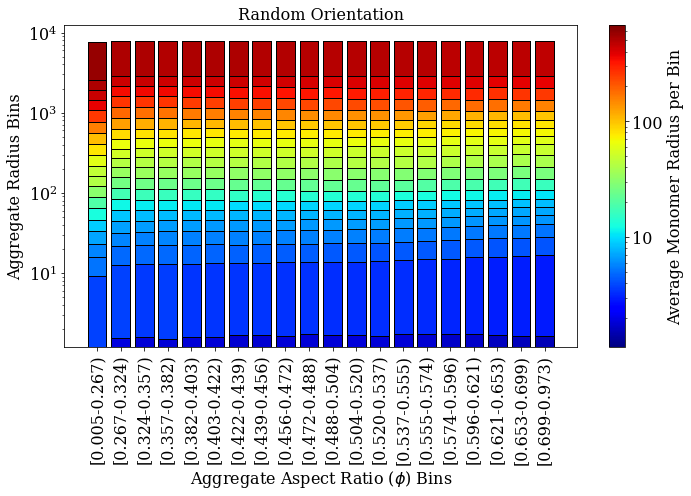

In [24]:
variable = avg_radius
cmap = plt.cm.jet
cb = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar_format = '%d'
cbar_label = 'Average Monomer Radius per Bin'
norm = matplotlib.colors.LogNorm(vmin=1.13, vmax=672)  # dependent on variable range
db.make_bar_plots(all_r_bins, variable, cmap, norm, phi_bin_labs,
                  x_axis_label, y_axis_label, cbar_format, cbar_label,
                  title, save_fig, save_name)


/network/rit/lab/sulialab/share/IPAS_3radii/scripts/database.py:130: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  plt.ylabel(y_axis_label)


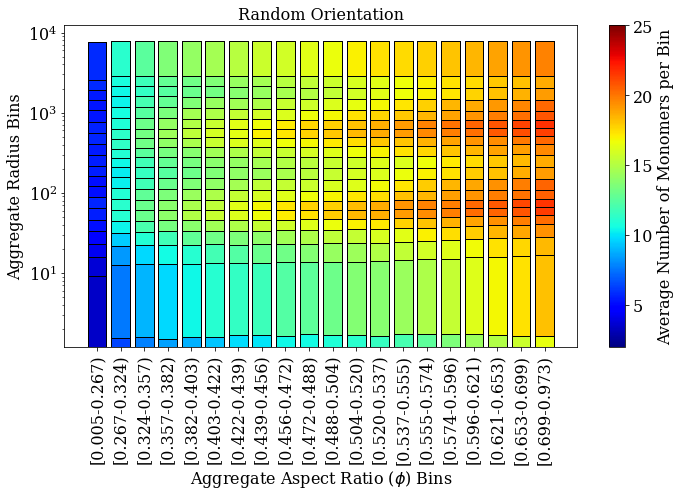

In [28]:
variable = avg_ncrystals
cmap = plt.cm.jet
cb = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar_format = '%d'
cbar_label = 'Average Number of Monomers per Bin'
norm = matplotlib.colors.Normalize(vmin=2, vmax=25)
db.make_bar_plots(all_r_bins, variable, cmap, norm, phi_bin_labs,
                  x_axis_label, y_axis_label, cbar_format, cbar_label,
                  title, save_fig, save_name)

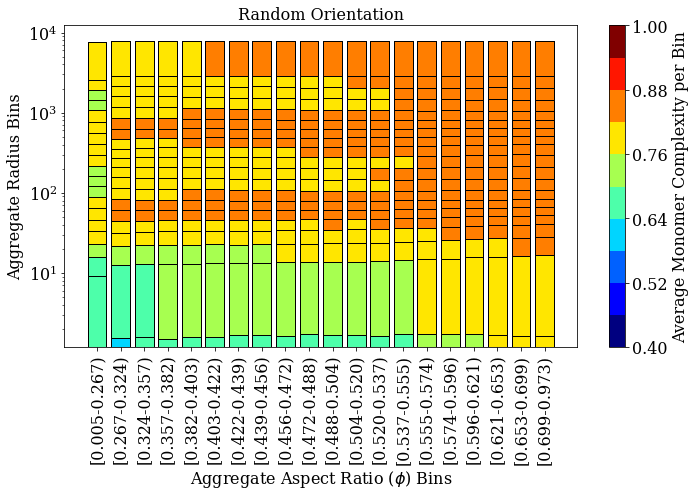

In [38]:
variable = avg_cplxs
bounds = np.linspace(0.4, 1.0, 11)
cmap = plt.cm.jet
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cbar_format = '%.2f'
cbar_label = 'Average Monomer Complexity per Bin'
db.make_bar_plots(all_r_bins, variable, cmap, norm, phi_bin_labs,
                  x_axis_label, y_axis_label, cbar_format, cbar_label,
                  title, save_fig, save_name)

In [34]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


/network/rit/lab/sulialab/share/bin/miniconda3/envs/IPAS/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  """


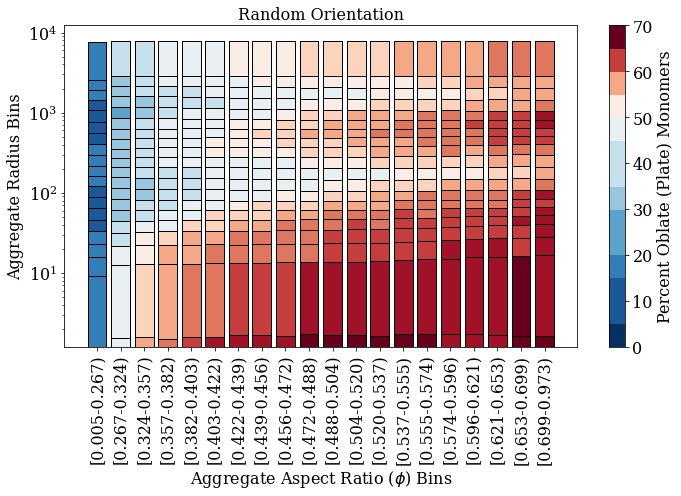

In [36]:
variable = agg_mono_phi
cmap = discrete_cmap(14,'RdBu_r')
cbar_format = '%d'
cbar_label = 'Percent Oblate (Plate) Monomers'
norm = matplotlib.colors.DivergingNorm(vmin=0, vcenter=50., vmax=70)
db.make_bar_plots(all_r_bins, variable, cmap, norm, phi_bin_labs,
                  x_axis_label, y_axis_label, cbar_format, cbar_label,
                  title, save_fig, save_name)